## In this notebook, we proceed to do the count vectorization, tf-idf and lda analysis of the topics present in both White House and European Commission

## Structure:
    - Hello is it me you are looking for?
    - Atomic by Blondie
    - First we take Manhanttan.

## Import functions

In [5]:
import pandas as pd
import numpy as np
import csv

import spacy
sp = spacy.load('en_core_web_sm')

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import os

from gensim.corpora.dictionary import Dictionary
from gensim import models
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus


from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from gensim.matutils import Sparse2Corpus
from gensim import corpora, models
import matplotlib.pyplot as plt


## Load Data

In [6]:
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename_EC ="data/theeuropeancommission_preprocessed.csv"
EC_data = pd.read_csv(os.path.join(path, filename_EC), sep=',', encoding='utf-8')
#Checking everything is fine
EC_data.head(5)

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,European Commission authorises second safe and...,2021-01-06,Press Release,"Today, the European Commission has granted a c...",today european commission grant conditional ma...,european commission authorise second safe effe...,0
1,Statement by President von der Leyen on the re...,2021-01-07,Statement,What happened in Washington yesterday is as ...,happen washington yesterday appalling outrageo...,statement president von der leyen recent devel...,0
2,Commission proposes to purchase up to 300 mill...,2021-01-08,Press Release,The European Commission today proposed to the ...,european commission today propose EU member st...,commission propose purchase 300 million additi...,0
3,Speech by President von der Leyen at the One P...,2021-01-11,Speech,"Merci Monsieur le Président.\nCher Emmanuel,\n...",merci monsieur le président cher emmanuel deli...,speech president von der leyen one planet summit,0
4,Coronavirus: Commission concludes exploratory ...,2021-01-12,Press Release,"Today, the European Commission concluded explo...",today european commission conclude exploratory...,coronavirus commission conclude exploratory ta...,0


In [7]:
filename ="data/thewhitehouse_preprocessed_p1.csv"
WH_data_1 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
filename ="data/thewhitehouse_preprocessed_p2.csv"
WH_data_2 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
WH_data = pd.concat([WH_data_1, WH_data_2], ignore_index=True)
#Checking everything is fine
WH_data.head(5)

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,Fact Sheet: President-elect Biden Outlines COV...,2021-01-15,Statement,Effectively and equitably vaccinating the U.S....,effectively equitably vaccinate US population ...,fact sheet president elect biden outlines covi...,0
1,Fact Sheet: List of Agency Actions for Review,2021-01-20,Statement,"Actions Address the COVID-19 Pandemic, Provide...",actions address covid19 pandemic provide econo...,fact sheet list agency actions review,0
2,Fact Sheet: President Biden Sends Immigration ...,2021-01-20,Statement,The U.S. Citizenship Act of 2021 establishes a...,US citizenship act 2021 establish new system r...,fact sheet president biden sends immigration b...,0
3,"A Letter to Dr. Eric S. Lander, the President’...",2021-01-20,Statement,"On January 15, 2021, then-President-Elect Bide...",january 15 2021 president elect biden send fol...,letter dr eric lander president science adviso...,0
4,Paris Climate Agreement,2021-01-20,Statement,ACCEPTANCE ON BEHALF OF THE UNITED STATES OF A...,acceptance ON BEHALF UNITED STATES AMERICA jos...,paris climate agreement,0


## CV, TD-IDF

In [25]:
def analyze_text_data(data, min_df, max_df):
    # Initialize CountVectorizer with specified parameters
    cv = CountVectorizer(ngram_range=(1,2), lowercase=True, min_df=min_df, max_df=max_df, stop_words='english')
    
    # Fit CountVectorizer and transform text and title data
    cv.fit(EC_data.text_preproc)
    vectorized_text = cv.transform(data.text_preproc).toarray()
    vectorized_title = cv.transform(data.titles_preproc).toarray()
    vectorized_text_title_weight = 2 * vectorized_title + vectorized_text
    
    # Apply SVD to CountVectorizer output
    svd = TruncatedSVD(n_components=10)
    U = svd.fit_transform(vectorized_text_title_weight)
    VT = svd.components_
    
    # Initialize TfidfVectorizer with specified parameters
    tfidf = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df=min_df, max_df=max_df, stop_words='english')
    
    # Fit and transform text data using TfidfVectorizer
    tfidf_matrix_text = tfidf.fit_transform(EC_data.text_preproc)
    tfidf_matrix_title = tfidf.transform(EC_data.titles_preproc)
    
    # Perform SVD on TF-IDF matrices
    svd_tfidf = TruncatedSVD(n_components=10)
    U_text = svd_tfidf.fit_transform(tfidf_matrix_text)
    U_title = svd_tfidf.transform(tfidf_matrix_title)
    
    # Print top words for Count Vectorization
    print("Top words associated with each topic (Count Vectorization):")
    feature_names_count = cv.get_feature_names_out()
    for topic_idx, topic in enumerate(VT):
        top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
        top_words = [feature_names_count[i] for i in top_words_idx]
        print(f"Topic {topic_idx+1}: {', '.join(top_words)}")
    
    # Print top words for TF-IDF Vectorization
    print("\nTop words associated with each topic (TF-IDF Vectorization):")
    feature_names_tfidf = tfidf.get_feature_names_out()
    for topic_idx, topic in enumerate(svd_tfidf.components_):
        top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
        top_words = [feature_names_tfidf[i] for i in top_words_idx]
        print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

analyze_text_data(EC_data, 0.02, 0.6)

Top words associated with each topic (Count Vectorization):
Topic 1: energy, plan, investment, ukraine, global, include, resilience, recovery, billion, climate
Topic 2: plan, resilience, recovery, recovery resilience, resilience plan, reform, investment, assessment, rrf, resilience facility
Topic 3: ukraine, war, russia, people, ukrainian, recovery, russian, assistance, reform, financial
Topic 4: include, cooperation, ukraine, international, security, global, continue, canada, development, health
Topic 5: vaccine, health, global, world, covid19, pandemic, digital, africa, million, dose
Topic 6: vaccine, energy, ukraine, million, africa, billion, health, covid19, team, team europe
Topic 7: vaccine, gas, member states, price, market, supply, defence, energy, measure, covid19
Topic 8: defence, investment, raw, critical, raw material, industry, material, strategic, critical raw, hydrogen
Topic 9: payment, request, global, recovery resilience, preliminary assessment, preliminary, payment re

In [17]:
# Define the range of min_df and max_df values
min_df_values = [0.001, 0.01, 0.02, 0.1]
max_df_values = [0.3, 0.4, 0.5, 0.6]

# Iterate through each combination of min_df and max_df values
print("European Commission Top words associated with each topic Count Vectorization and TF-IDF Vectorization:")
for min_df in min_df_values:
    for max_df in max_df_values:
        # Print the current combination of min_df and max_df being analyzed
        print(f"\nAnalyzing with min_df = {min_df} and max_df = {max_df}:")
        
        # Call the analyze_text_data function for the current combination
        analyze_text_data(EC_data, min_df, max_df)


European Commission Top words associated with each topic Count Vectorization and TF-IDF Vectorization:

Analyzing with min_df = 0.001 and max_df = 0.4:
Top words associated with each topic (Count Vectorization):
Topic 1: ukraine, resilience, recovery, digital, transition, recovery resilience, reform, security, russia, von
Topic 2: resilience, recovery, recovery resilience, resilience plan, reform, assessment, digital, rrf, resilience facility, facility
Topic 3: ukraine, war, russia, ukrainian, recovery, financial, assistance, russian, reform, recovery resilience
Topic 4: vaccine, health, covid19, africa, dose, pandemic, team, team europe, production, covid19 vaccine
Topic 5: security, health, canada, development, ukraine, vaccine, partnership, welcome, strengthen, commitment
Topic 6: transition, ukraine, viet, viet nam, nam, emission, renewable, energy transition, hydrogen, africa
Topic 7: defence, gas, supply, vaccine, price, industry, security, critical, industrial, russia
Topic 8: r

In [20]:
print("White House Top words associated with each topic Count Vectorization and TF-IDF Vectorization:")
for min_df in min_df_values:
    for max_df in max_df_values:
        # Print the current combination of min_df and max_df being analyzed
        print(f"\nAnalyzing with min_df = {min_df} and max_df = {max_df}:")
        
        # Call the analyze_text_data function for the current combination
        analyze_text_data(WH_data, min_df, max_df)

White House Top words associated with each topic Count Vectorization and TF-IDF Vectorization:

Analyzing with min_df = 0.001 and max_df = 0.4:
Top words associated with each topic (Count Vectorization):
Topic 1: say, think, want, look, question, talk, ahead, plan, sure, thing
Topic 2: health, program, care, investment, energy, climate, law, access, federal, billion
Topic 3: applause, job, pay, cost, say, drug, inflation, laughter, act, folk
Topic 4: energy, climate, ukraine, russia, global, clean, international, technology, action, clean energy
Topic 5: serve, law, university, school, department, member, service, district, court, justice
Topic 6: care, tweet, cost, ahead, drug, act, inflation, health, americans, price
Topic 7: law, university, serve, vaccine, drug, inflation, energy, reduction, inflation reduction, reduction act
Topic 8: health, care, tweet, ukraine, drug, applause, global, mental, mental health, woman
Topic 9: term, russia, ukraine, price, release, supervised, think,

## LDA and topics analysis

In [8]:
def analyze_text_with_lda(data, min_df, max_df):
    # Initialize CountVectorizer
    cv = CountVectorizer(ngram_range=(1, 2), lowercase=False, min_df=min_df, max_df=max_df)
    
    # Fit CountVectorizer and transform text data
    cv.fit(data.text_preproc)
    vectorized_text = cv.transform(data.text_preproc).toarray()
    vectorized_title = cv.transform(data.titles_preproc).toarray()

    # Combine text and title vectorized data with specified weight
    dtm = 2 * vectorized_title + vectorized_text

    # Convert the combined DTM to a sparse format for gensim
    dtm_sparse = csr_matrix(dtm)

    # Convert sparse matrix to gensim corpus
    corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

    # Create a Gensim dictionary from the CountVectorizer vocabulary
    dictionary = Dictionary()
    cv_vocabulary = {id_: token for token, id_ in cv.vocabulary_.items()}
    # Manually populate the Dictionary object
    dictionary.id2token = cv_vocabulary
    dictionary.token2id = {token: id_ for id_, token in cv_vocabulary.items()}

    # Hardcoded parameters for LDA
    num_topics = 10
    passes = 10
    random_state = 10

    # Build LDA model
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=random_state)

    # Display the topics
    print("Top words associated with each topic (LDA):")
    topics = lda_model.show_topics(num_words=10, formatted=False)
    for topic_num, topic_words in topics:
        words = ', '.join([word for word, _ in topic_words])
        print(f"Topic {topic_num + 1}: {words}")

    return lda_model, corpus



In [38]:
# Define the range of min_df and max_df values
min_df_values = [0.001, 0.01, 0.02, 0.1]
max_df_values = [0.3, 0.4, 0.5, 0.6]

# Iterate through each combination of min_df and max_df values
print("European Commission Top words associated with each topic with LDA:")
for min_df in min_df_values:
    for max_df in max_df_values:
        # Print the current combination of min_df and max_df being analyzed
        print(f"\nAnalyzing with min_df = {min_df} and max_df = {max_df}:")
        
        # Call the analyze_text_data function for the current combination
        analyze_text_with_lda(EC_data, min_df, max_df)


European Commission Top words associated with each topic Count Vectorization and TF-IDF Vectorization:

Analyzing with min_df = 0.001 and max_df = 0.4:
Top words associated with each topic (LDA):
Topic 1: resilience, recovery, recovery resilience, resilience plan, digital, reform, measure, transition, RRF, NextGenerationEU
Topic 2: gateway, global gateway, africa, partnership, raw, development, sustainable, team, raw material, material
Topic 3: ukraine, western, financial, assistance, balkans, western balkans, ukrainian, war, reform, russia
Topic 4: ukraine, digital, von, der leyen, leyen, von der, der, example, president von, change
Topic 5: vaccine, health, dose, von, von der, leyen, der leyen, der, pandemic, president von
Topic 6: ukraine, woman, defence, der, von der, der leyen, von, leyen, security, president von
Topic 7: ukraine, russia, russian, war, gas, china, sanction, der leyen, von der, der
Topic 8: hydrogen, partnership, transition, emission, clean, renewable, agreement, c

In [ ]:
# Define the range of min_df and max_df values
min_df_values = [0.001, 0.01, 0.02, 0.1]
max_df_values = [0.3, 0.4, 0.5, 0.6]

# Iterate through each combination of min_df and max_df values
print("European Commission Top words associated with each topic Count Vectorization and TF-IDF Vectorization:")
for min_df in min_df_values:
    for max_df in max_df_values:
        # Print the current combination of min_df and max_df being analyzed
        print(f"\nAnalyzing with min_df = {min_df} and max_df = {max_df}:")
        
        # Call the analyze_text_data function for the current combination
        analyze_text_with_lda(WH_data, min_df, max_df)


In [9]:
#We choose one lda and then role it, this is for text purposes
lda_model_ECB, corpus_ECB = analyze_text_with_lda(EC_data, 0.02, 0.6)
lda_model_WH, corpus_WH = analyze_text_with_lda(WH_data, 0.02, 0.6)

Top words associated with each topic (LDA):
Topic 1: vaccine, health, global, dose, pandemic, COVID19, million, member states, africa, world
Topic 2: ukraine, member states, energy, financial, billion, assistance, security, million, provide, include
Topic 3: people, woman, der leyen, von der, der, von, leyen, president von, life, thank
Topic 4: climate, global, green, change, emission, climate change, world, biodiversity, want, carbon
Topic 5: economic, western, ukraine, cooperation, balkans, western balkans, reform, important, investment, include
Topic 6: plan, green, investment, social, market, economy, know, recovery, NextGenerationEU, example
Topic 7: plan, resilience, recovery, recovery resilience, investment, resilience plan, reform, billion, digital, facility
Topic 8: digital, agreement, bauhaus, new european, european bauhaus, trade, AI, future, people, der
Topic 9: ukraine, russia, war, energy, world, one, want, russian, people, time
Topic 10: energy, global, investment, partn

In [10]:
def aggregate_topic_shares(data, lda_model, corpus):
    # Get document topics
    doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]
    
    # Initialize topic columns in EC_data
    for topic_num in range(10):
        data[f'topic_{topic_num}'] = 0.0
    
    # Fill topic share in EC_data
    for i, doc_distribution in enumerate(doc_topics):
        for topic_num, prob in doc_distribution:
            data.at[i, f'topic_{topic_num}'] = prob
    
    # Calculate sum of topic shares and check if it's close to 1
    data['topic_sum'] = data[[f'topic_{i}' for i in range(10)]].sum(axis=1)
    data['sum_is_1'] = np.isclose(data['topic_sum'], 1.0)
    
    # Calculate words per topic
    data['length_in_words'] = data['text_preproc'].apply(lambda x: len(x.split()))
    for i in range(10):
        data[f'words_topic_{i}'] = data[f'topic_{i}'] * data['length_in_words']
    
    # Correctly convert the 'Date' column to 'year_month' format
    data['year_month'] = pd.to_datetime(data['Date']).dt.strftime('%Y-%m')
    aggregation_data = data[['year_month'] + [f'words_topic_{i}' for i in range(10)]]
    grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()
    
    # Adjust sums by alpha_prior and calculate topic shares
    alpha_prior = lda_model.alpha
    total_alpha_prior = sum(alpha_prior)
    for i in range(10):
        grouped_data[f'topic_share_{i}'] = (grouped_data[f'words_topic_{i}'] + alpha_prior[i]) / (grouped_data[[f'words_topic_{j}' for j in range(10)]].sum(axis=1) + total_alpha_prior)
    
    # Select final columns for the result DataFrame
    final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(10)]
    result_df = grouped_data[final_columns]
    
    return result_df

EC_topic_shares = aggregate_topic_shares(EC_data, lda_model_ECB, corpus_ECB)
WH_topic_shares = aggregate_topic_shares(WH_data, lda_model_WH, corpus_WH)

In [11]:
EC_topic_shares.head(5)

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4,topic_share_5,topic_share_6,topic_share_7,topic_share_8,topic_share_9
0,2021-01,0.356892,0.003795,0.096965,0.161241,0.015841,0.135680,0.001440,0.103094,0.101917,0.023136
1,2021-02,0.329354,0.006288,0.139205,0.021685,0.022975,0.358524,0.032891,0.041025,0.034469,0.013585
2,2021-03,0.238231,0.039556,0.185921,0.145070,0.039599,0.159665,0.025212,0.111128,0.044852,0.010765
3,2021-04,0.238909,0.047434,0.237715,0.116636,0.072486,0.059975,0.033427,0.168863,0.023780,0.000774
4,2021-05,0.317908,0.070887,0.180929,0.068403,0.057165,0.146929,0.013313,0.067915,0.024737,0.051813


In [ ]:
WH_topic_shares.head(5)

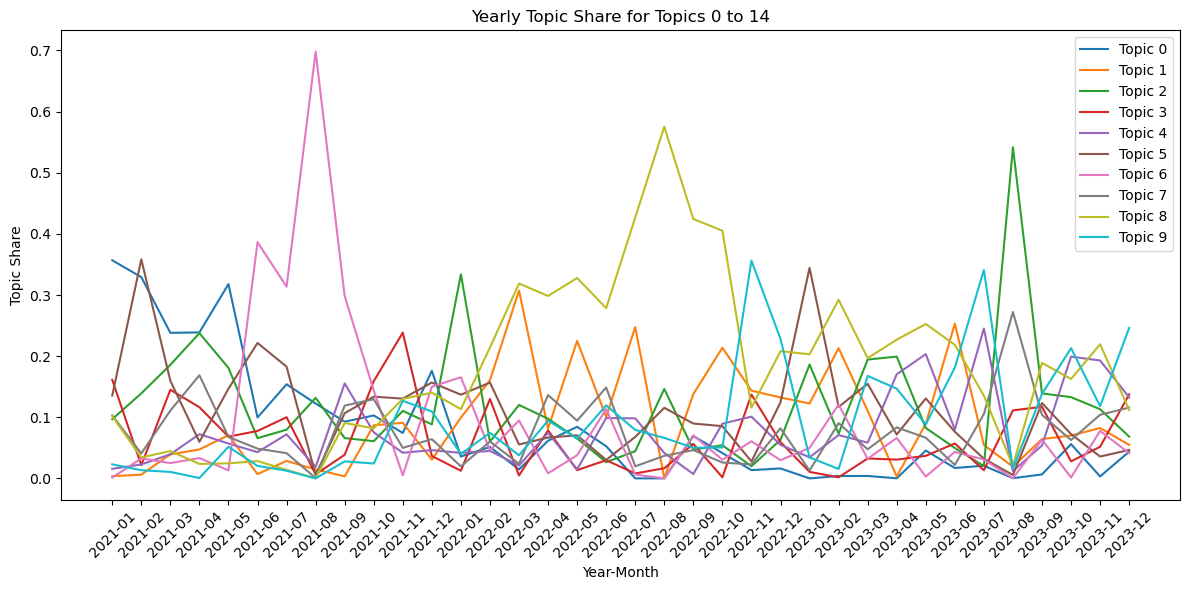

In [13]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
for i in range(10):  # Assuming topic_share columns are named from 'topic_share_0' to 'topic_share_14'
    plt.plot(EC_topic_shares['year_month'], EC_topic_shares[f'topic_share_{i}'], label=f'Topic {i}')

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 0 to 14')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()

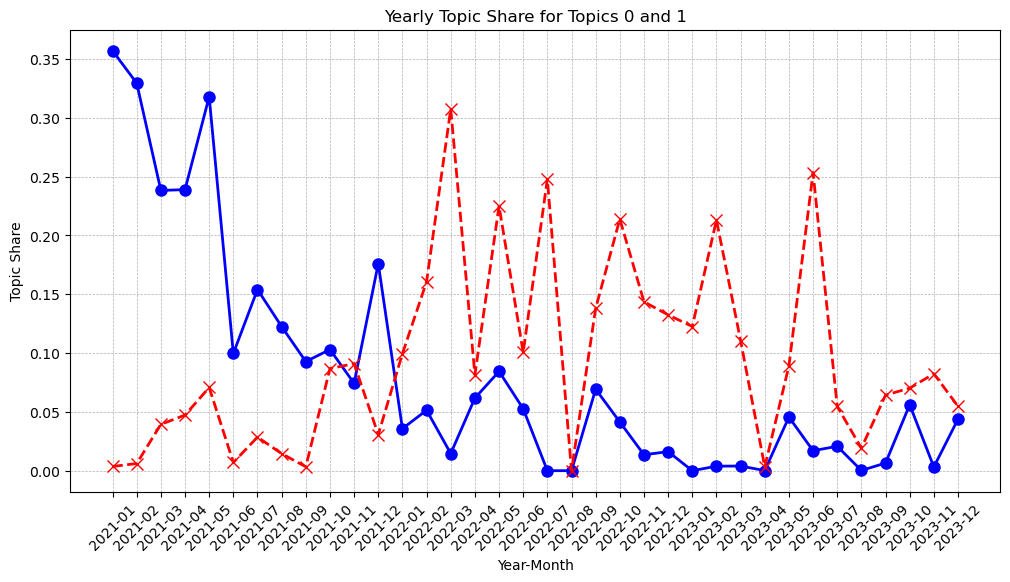

In [14]:
def plot_topic_shares_over_time(result_df, topic1, topic2):
    plt.figure(figsize=(12, 6))  # Increase figure size for better readability
    
    # Plot for the first selected topic with improved line style and marker size
    plt.plot(result_df['year_month'], result_df[f'topic_share_{topic1}'], label=f'Topic {topic1}',
             marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
    
    # Plot for the second selected topic with different line style and marker size
    plt.plot(result_df['year_month'], result_df[f'topic_share_{topic2}'], label=f'Topic {topic2}',
             marker='x', linestyle='--', color='red', linewidth=2, markersize=8)
    
    # Rotate the x-axis tick labels for better readability
    plt.xticks(rotation=45)
    
    # Adding labels, title, and gridlines
    plt.xlabel('Year-Month')
    plt.ylabel('Topic Share')
    plt.title(f'Yearly Topic Share for Topics {topic1} and {topic2}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add


plot_topic_shares_over_time(EC_topic_shares, 0, 1)